Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Diffusion Autoencoder Tutorial with Image Manipulation

This tutorial illustrates how to use MONAI Generative Models for training a 2D Diffusion Autoencoder model [1].

In summary, the tutorial will cover the following:
1. Training a 2D diffusion model and semantic encoder with a ResNet18 backbone;
2. Evaluate the learned latent space by applying a Logistic Regression classifier and manipulating images with using the direction learned by the classifier.

We will us the 2D MRI slices from 3D BraTS volumes [2].


During inference, the model encodes the image to latent space which is used as conditioning for the U-Net=based diffusion model. [1] trains a latent diffusion model for being able to generate unconditional images, which we do not do in this tutorial. Here, we are interested in checking wether the latent space contains classification information or not and if can be used to manipulate the images.

[1] Preechakul et al. [Diffusion Autoencoders: Toward a Meaningful and Decodable Representation](https://arxiv.org/abs/2111.15640). CVPR 2022<br>
[2] Menze, B. H., Jakab, A., Bauer, S., Kalpathy-Cramer, J., Farahani, K., Kirby, J., Burren, Y., Porz, N., Slotboom, J., Wiest, R., Lanczi, L., Gerstner, E., Weber, M.-A., Arbel, T., Avants, B. B., Ayache, N., Buendia, P., Collins, D. L., Cordier, N., … van Leemput, K. (2015). The Multimodal Brain Tumor Image Segmentation Benchmark (BRATS). IEEE Transactions on Medical Imaging, 34(10), 1993–2024. https://doi.org/10.1109/TMI.2014.2377694

![image.png](https://diff-ae.github.io/images/diffae_overview.jpg)

In this tutorial, then, we train an image encoder and DDPM jointly, so that the generative process is always guided by the latent representation of the encoder. The latent space can then be manipulated in the direction of specific clusters (e.g. anomaly, healthy) using logistic regression, forcing the DDPM sample to lean more towards a specific phenotype conveyed by the latent space.


## Setup environment 

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
!pip install -q scikit-learn
%matplotlib inline


[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


## Setup imports

In [ ]:
import os
import tempfile
import time
import matplotlib.pyplot as plt
import numpy as np
import shutil
import torch
import torch.nn.functional as F
import torchvision
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.utils import set_determinism
from sklearn.linear_model import LogisticRegression

from monai.inferers import DiffusionInferer
from monai.networks.nets.diffusion_model_unet import DiffusionModelUNet
from monai.networks.schedulers.ddim import DDIMScheduler

torch.multiprocessing.set_sharing_strategy("file_system")

print_config()

## Setup data directory

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory

## Set deterministic training for reproducibility

In [4]:
set_determinism(42)

## Setup BRATS Dataset  - Transforms for extracting 2D slices from 3D volumes

We now download the BraTS dataset and extract the 2D slices from the 3D volumes. The `slice_label` is used to indicate whether the slice contains an anomaly or not.

Here we use transforms to augment the training dataset, as usual:

1. `LoadImaged` loads the brain images from files.
2. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
3.  The first `Lambdad` transform chooses the first channel of the image, which is the Flair image.
4. `Spacingd` resamples the image to the specified voxel spacing, we use 3,3,2 mm.
5. `CenterSpatialCropd`: we crop the 3D images to a specific size
6. `ScaleIntensityRangePercentilesd` Apply range scaling to a numpy array based on the intensity distribution of the input. Transform is very common with MRI images.
7. `RandSpatialCropd` randomly crop out a 2D patch from the 3D image.
6. The last `Lambdad` transform obtains `slice_label` by summing up the label to have a single scalar value (healthy `=1` or not `=2` ).

In [5]:
channel = 0  # 0 = Flair
assert channel in [0, 1, 2, 3], "Choose a valid channel"

train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        transforms.EnsureChannelFirstd(keys=["image", "label"]),
        transforms.Lambdad(keys=["image"], func=lambda x: x[channel, None, :, :, :]),
        transforms.EnsureTyped(keys=["image", "label"]),
        transforms.Orientationd(keys=["image", "label"], axcodes="RAS"),
        transforms.Spacingd(keys=["image", "label"], pixdim=(3.0, 3.0, 2.0), mode=("bilinear", "nearest")),
        transforms.CenterSpatialCropd(keys=["image", "label"], roi_size=(64, 64, 44)),
        transforms.ScaleIntensityRangePercentilesd(keys="image", lower=0, upper=99.5, b_min=0, b_max=1),
        transforms.RandSpatialCropd(keys=["image", "label"], roi_size=(64, 64, 1), random_size=False),
        transforms.Lambdad(keys=["image", "label"], func=lambda x: x.squeeze(-1)),
        transforms.CopyItemsd(keys=["label"], times=1, names=["slice_label"]),
        transforms.Lambdad(keys=["slice_label"], func=lambda x: 1.0 if x.sum() > 0 else 0.0),
    ]
)

### Load Training and Validation Datasets

In [6]:
# Parameters
batch_size = 12

In [7]:
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="training",
    cache_rate=1.0,  # you may need a few Gb of RAM... Set to 0 otherwise
    num_workers=4,
    download=True,  # Set download to True if the dataset hasnt been downloaded yet
    seed=0,
    transform=train_transforms,
)
print(f"Length of training data: {len(train_ds)}")
print(f'Train image shape {train_ds[0]["image"].shape}')

Loading dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 388/388 [01:57<00:00,  3.30it/s]

Length of training data: 388
Train image shape torch.Size([1, 64, 64])


In [9]:
val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="validation",
    cache_rate=1,  # you may need a few Gb of RAM... Set to 0 otherwise
    num_workers=4,
    download=True,  # Set download to True if the dataset hasnt been downloaded yet
    seed=0,
    transform=train_transforms,
)
print(f"Length of training data: {len(val_ds)}")
print(f'Validation Image shape {val_ds[0]["image"].shape}')

Loading dataset: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:29<00:00,  3.22it/s]

Length of training data: 96
Validation Image shape torch.Size([1, 64, 64])


We create the dataloaders:

In [10]:
train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True, persistent_workers=True
)
val_loader = DataLoader(
    val_ds, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True, persistent_workers=True
)

## Define network, scheduler, optimizer, and inferer

At this step, we instantiate the MONAI components to create a DDIM, the U-Net with conditioning, the noise scheduler, and the inferer used for training and sampling. We are using
the deterministic DDIM scheduler containing 1000 timesteps, and a 2D U-Net with attention mechanisms.

The `attention` mechanism is essential for ensuring good conditioning and images manipulation here.

The `embedding_dimension` parameter controls the dimension of the latent dimension learned by the semantic encoder.


In [11]:
class DiffusionAE(torch.nn.Module):
    def __init__(self, embedding_dimension=64):
        super().__init__()
        self.unet = DiffusionModelUNet(
            spatial_dims=2,
            in_channels=1,
            out_channels=1,
            channels=(64, 128, 256),
            attention_levels=(False, False, True),
            num_res_blocks=1,
            num_head_channels=[64, 128, 256],
            with_conditioning=True,
            cross_attention_dim=1,
        )
        self.semantic_encoder = torchvision.models.resnet18()
        self.semantic_encoder.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.semantic_encoder.fc = torch.nn.Linear(512, embedding_dimension)

    def forward(self, xt, x_cond, t):
        latent = self.semantic_encoder(x_cond)
        noise_pred = self.unet(x=xt, timesteps=t, context=latent.unsqueeze(2))
        return noise_pred, latent


device = "cuda" if torch.cuda.is_available() else "cpu"
model = DiffusionAE(embedding_dimension=512).to(device)
scheduler = DDIMScheduler(num_train_timesteps=1000)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-5)
inferer = DiffusionInferer(scheduler)

## Training the diffusion model and the semantic encoder

In [12]:
# training for longer (1e4 ~ 3h) helps a lot with reconstruction quality, even if the loss is already low
max_epochs = 1000
val_interval = 100
print_interval = 50
iter_loss_list, val_iter_loss_list = [], []
iter_loss = 0

total_start = time.time()

for epoch in range(max_epochs):
    for step, batch in enumerate(train_loader):
        model.train()
        optimizer.zero_grad(set_to_none=True)
        images = batch["image"].to(device)
        noise = torch.randn_like(images).to(device)
        # Create timesteps
        timesteps = torch.randint(0, inferer.scheduler.num_train_timesteps, (batch_size,)).to(device).long()
        # Get model prediction
        # cross attention expects shape [batch size, sequence length, channels],
        # we are use channels = latent dimension and sequence length = 1
        latent = model.semantic_encoder(images)
        noise_pred = inferer(
            inputs=images, diffusion_model=model.unet, noise=noise, timesteps=timesteps, condition=latent.unsqueeze(2)
        )
        loss = F.mse_loss(noise_pred.float(), noise.float())

        loss.backward()
        optimizer.step()

        iter_loss += loss.item()
        if epoch % print_interval == 0 and step == len(train_loader) - 1:
            print(f"Iteration {epoch}/{max_epochs} - train Loss {loss.item():.4f}" + "\r")

    if epoch % val_interval == 0:
        model.eval()
        val_iter_loss = 0
        for _, val_batch in enumerate(val_loader):
            with torch.no_grad():
                images = val_batch["image"].to(device)
                timesteps = torch.randint(0, inferer.scheduler.num_train_timesteps, (batch_size,)).to(device).long()
                noise = torch.randn_like(images).to(device)
                latent = model.semantic_encoder(images)
                noise_pred = inferer(
                    inputs=images,
                    diffusion_model=model.unet,
                    noise=noise,
                    timesteps=timesteps,
                    condition=latent.unsqueeze(2),
                )
                val_loss = F.mse_loss(noise_pred.float(), noise.float())

            val_iter_loss += val_loss.item()
        iter_loss_list.append(iter_loss / val_interval)
        val_iter_loss_list.append(val_iter_loss / len(val_loader))
        iter_loss = 0
        to_print = [
            f"Iteration {epoch} - Interval Loss {iter_loss_list[-1]:.4f}",
            f"Interval Loss Val {val_iter_loss_list[-1]:.4f}",
        ]
        print("".join(to_print))

total_time = time.time() - total_start

print(f"train diffusion completed, total time: {total_time}.")

Iteration 0/1000 - train Loss 0.9465
Iteration 0 - Interval Loss 0.3134, Interval Loss Val 0.9484
Iteration 50/1000 - train Loss 0.0050
Iteration 100/1000 - train Loss 0.0565
Iteration 100 - Interval Loss 3.7005, Interval Loss Val 0.0101
Iteration 150/1000 - train Loss 0.0092
Iteration 200/1000 - train Loss 0.0124
Iteration 200 - Interval Loss 0.5862, Interval Loss Val 0.0161
Iteration 250/1000 - train Loss 0.0138
Iteration 300/1000 - train Loss 0.0226
Iteration 300 - Interval Loss 0.5498, Interval Loss Val 0.0215
Iteration 350/1000 - train Loss 0.0175
Iteration 400/1000 - train Loss 0.0308
Iteration 400 - Interval Loss 0.5473, Interval Loss Val 0.0150
Iteration 450/1000 - train Loss 0.0021
Iteration 500/1000 - train Loss 0.0102
Iteration 500 - Interval Loss 0.5300, Interval Loss Val 0.0249
Iteration 550/1000 - train Loss 0.0159
Iteration 600/1000 - train Loss 0.0838
Iteration 600 - Interval Loss 0.5258, Interval Loss Val 0.0223
Iteration 650/1000 - train Loss 0.0290
Iteration 700/1000

We plot the learning curves:

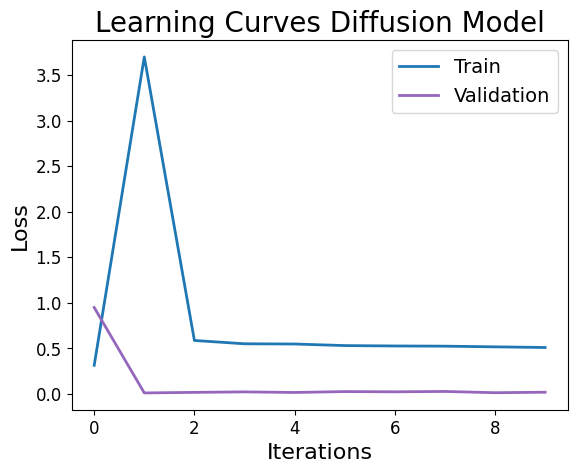

In [13]:
plt.title("Learning Curves Diffusion Model", fontsize=20)
plt.plot(list(range(len(iter_loss_list))), iter_loss_list, color="C0", linewidth=2.0, label="Train")
plt.plot(list(range(len(iter_loss_list))), val_iter_loss_list, color="C4", linewidth=2.0, label="Validation")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Iterations", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()

# Evaluation
## Generate synthetic data

We use the semantic encoder to get a latent space from the validation dataset. We then use the diffusion model to generate synthetic data from the latent space.

In [17]:
scheduler.set_timesteps(num_inference_steps=100)
batch = next(iter(val_loader))
images = batch["image"].to(device)
noise = torch.randn_like(images).to(device)
latent = model.semantic_encoder(images)
reconstruction = inferer.sample(
    input_noise=noise,
    diffusion_model=model.unet,
    scheduler=scheduler,
    save_intermediates=False,
    conditioning=latent.unsqueeze(2),
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.10it/s]


(-0.5, 529.5, 133.5, -0.5)

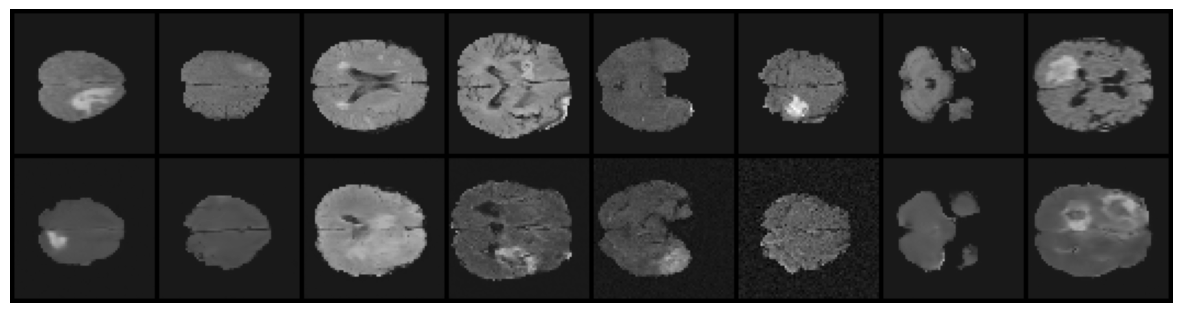

In [18]:
grid = torchvision.utils.make_grid(
    torch.cat([images[:8], reconstruction[:8]]), nrow=8, padding=2, normalize=True, scale_each=False, pad_value=0
)
plt.figure(figsize=(15, 5))
plt.imshow(grid.detach().cpu().numpy()[0], cmap="gray")
plt.axis("off")

## Evaluate Latent Space

First, obtain the latent space from the entire training and validation datasets.
Then, we train a logistic regression classifier on the latent space.

In [19]:
# get latent space of training set
latents_train = []
classes_train = []
# 15 slices from each volume
nb_slices_per_volume = 15
for _ in range(nb_slices_per_volume):
    for batch in train_loader:
        images = batch["image"].to(device)
        latent = model.semantic_encoder(images)
        latents_train.append(latent.detach().cpu().numpy())
        classes_train.append(batch["slice_label"].numpy())

latents_train = np.concatenate(latents_train, axis=0)
classes_train = np.concatenate(classes_train, axis=0)

# get latent space of validation set
latents_val = []
classes_val = []
for batch in val_loader:
    images = batch["image"].to(device)
    latent = model.semantic_encoder(images)
    latents_val.append(latent.detach().cpu().numpy())
    classes_val.append(batch["slice_label"].numpy())
latents_val = np.concatenate(latents_val, axis=0)
classes_val = np.concatenate(classes_val, axis=0)

In [20]:
print(latents_train.shape)
print(classes_train.shape)

((5760, 512), (5760,))

In [21]:
clf = LogisticRegression(solver="newton-cg", random_state=0).fit(latents_train, classes_train)
print(clf.score(latents_train, classes_train))
print(clf.score(latents_val, classes_val))

(0.8217013888888889, 0.7395833333333334)

## Manipulate Latent Space

The logistic regression classifier learns a direction `w` in the latent space that separates the healthy and abnormal slices. We can use this direction to manipulate the images by `latent = latent + s * w`, where `s` controls the strength of the manipulation. Negative `s` will move the image in the opposite direction.

In [26]:
s = -1.5

w = torch.Tensor(clf.coef_).float().to(device)
scheduler.set_timesteps(num_inference_steps=100)
batch = next(iter(val_loader))
images = batch["image"].to(device)
noise = torch.randn_like(images).to(device)

latent = model.semantic_encoder(images)
w_ = torch.cat([w] * images.shape[0], 0)
latent_manip = latent + s * w[0]

reconstruction = inferer.sample(
    input_noise=noise,
    diffusion_model=model.unet,
    scheduler=scheduler,
    save_intermediates=False,
    conditioning=latent.unsqueeze(2),
)
manipulated_images = inferer.sample(
    input_noise=noise,
    diffusion_model=model.unet,
    scheduler=scheduler,
    save_intermediates=False,
    conditioning=latent_manip.unsqueeze(2),
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.93it/s]


Although not perfectly, the manipulated slices do not present a tumour (unlike the middle - "reconstructed" - ones), because we tweaked the latents to move away from the abnormality cluster: 

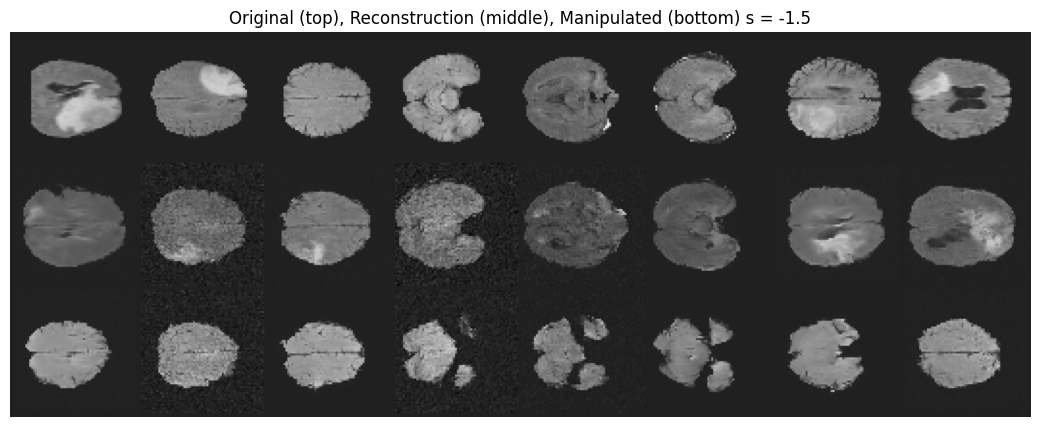

In [28]:
nb = 8
grid = torchvision.utils.make_grid(
    torch.cat([images[:nb], reconstruction[:nb], manipulated_images[:nb]]),
    nrow=8,
    normalize=False,
    scale_each=False,
    pad_value=0,
)
plt.figure(figsize=(15, 5))
plt.imshow(grid.detach().cpu().numpy()[0], cmap="gray")
plt.axis("off")
plt.title(f"Original (top), Reconstruction (middle), Manipulated (bottom) s = {s}")

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)